# Bottle Cap Detection - Model Development
**Author:** Wikan Priambudi
**Goal:** Develop a lightweight detection model (<10ms inference) for Raspberry Pi 5.

## Data Understanding

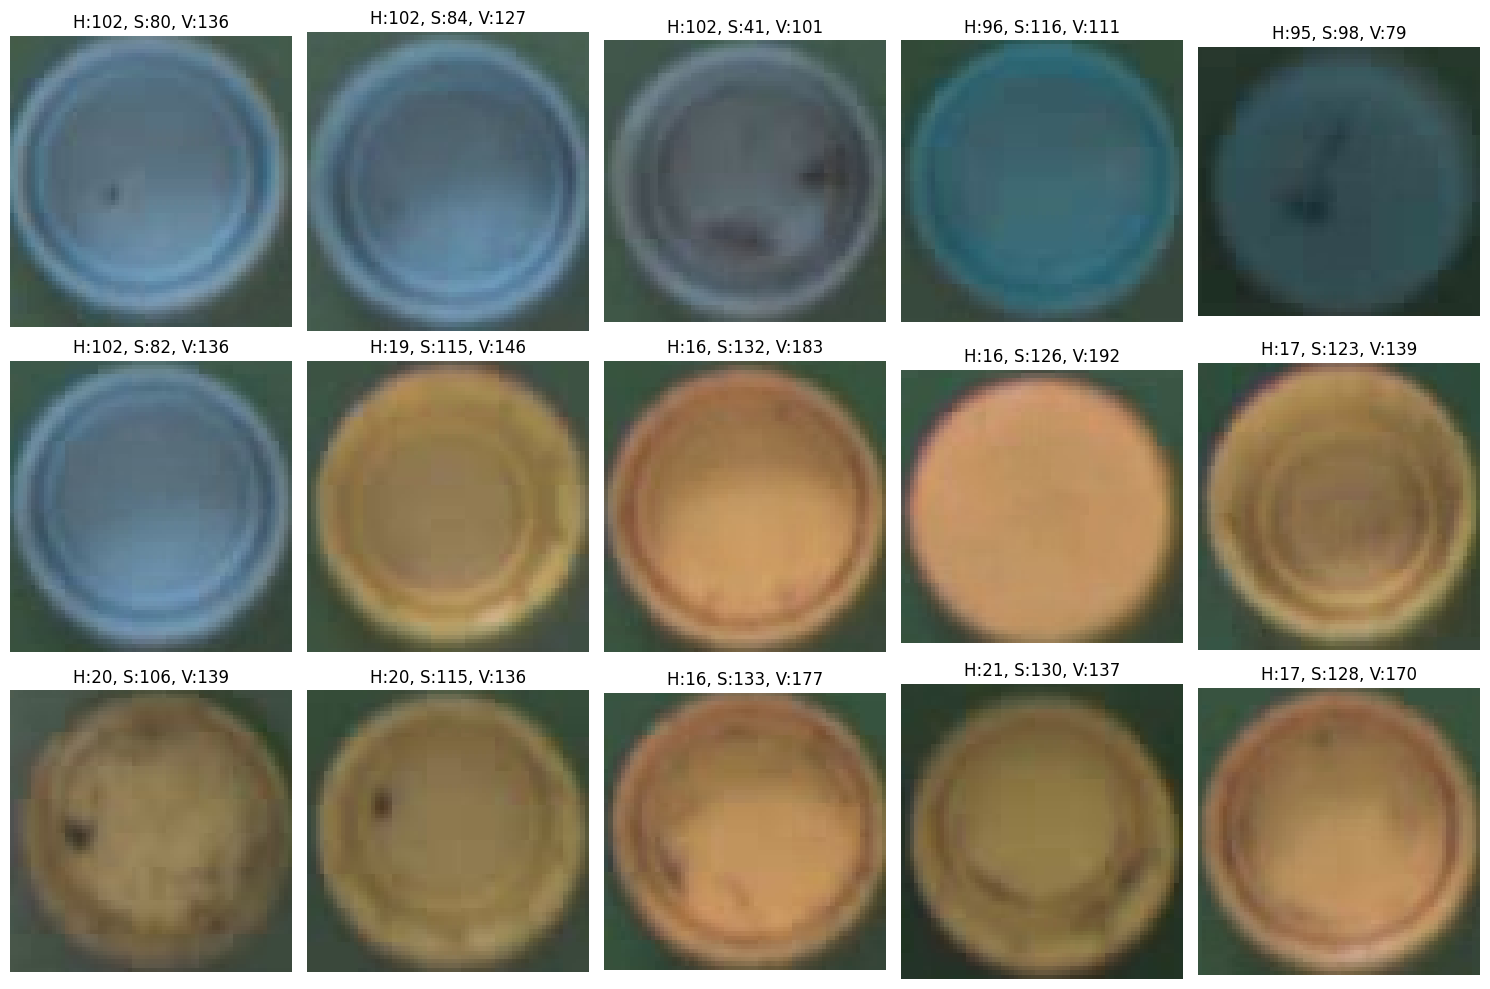

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Ambil beberapa sampel gambar dari folder train
image_files = glob.glob("../datasets/bottle_cap/train/images/*.jpg")[:5] # Ambil 3 gambar saja dulu

def get_hsv_stats(img_path, label_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, w, _ = img.shape
    
    crops = []
    stats = []
    
    if not os.path.exists(label_path): return [], []
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        # Koordinat YOLO
        x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Convert ke pixel
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        # Pastikan koordinat valid
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        # Ambil crop (potongan gambar tutup botol)
        crop_rgb = img_rgb[y1:y2, x1:x2]
        crop_hsv = img_hsv[y1:y2, x1:x2]
        
        if crop_rgb.size == 0: continue
            
        # Ambil bagian tengah saja (50%) untuk hindari background
        cy, cx = crop_hsv.shape[:2]
        center_hsv = crop_hsv[int(cy*0.25):int(cy*0.75), int(cx*0.25):int(cx*0.75)]
        
        # Hitung rata-rata H, S, V
        mean_h = np.mean(center_hsv[:,:,0]) # Hue (0-179 di OpenCV)
        mean_s = np.mean(center_hsv[:,:,1]) # Saturation (0-255)
        mean_v = np.mean(center_hsv[:,:,2]) # Value (0-255)
        
        crops.append(crop_rgb)
        stats.append((mean_h, mean_s, mean_v))
        
    return crops, stats

# Visualisasi
plt.figure(figsize=(15, 10))
k = 1
for img_file in image_files:
    lbl_file = img_file.replace('images', 'labels').replace('.jpg', '.txt')
    crops, stats = get_hsv_stats(img_file, lbl_file)
    
    for crop, stat in zip(crops, stats):
        if k > 15: break # Jangan kebanyakan plot
        plt.subplot(3, 5, k)
        plt.imshow(crop)
        plt.title(f"H:{stat[0]:.0f}, S:{stat[1]:.0f}, V:{stat[2]:.0f}")
        plt.axis('off')
        k += 1

plt.tight_layout()
plt.show()

Menganalisis 12 gambar... Mohon tunggu.


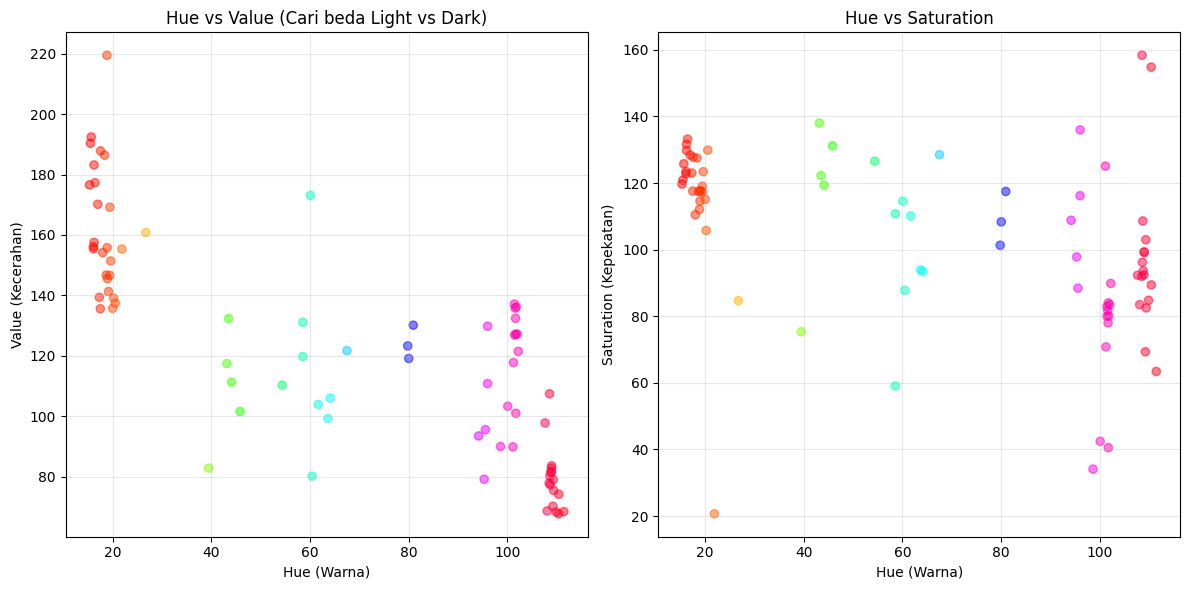

Total Tutup Botol terdeteksi: 79


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Ambil SEMUA gambar di folder train dan valid
train_images = glob.glob("../datasets/bottle_cap/train/images/*.jpg")
val_images = glob.glob("../datasets/bottle_cap/valid/images/*.jpg")
all_images = train_images + val_images

h_values = []
s_values = []
v_values = []

print(f"Menganalisis {len(all_images)} gambar... Mohon tunggu.")

for img_path in all_images:
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
    if not os.path.exists(label_path): continue
    
    img = cv2.imread(img_path)
    if img is None: continue
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_img, w_img, _ = img.shape
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Convert ke pixel
        x1 = int((x_c - bw/2) * w_img)
        y1 = int((y_c - bh/2) * h_img)
        x2 = int((x_c + bw/2) * w_img)
        y2 = int((y_c + bh/2) * h_img)
        
        # Crop dan ambil tengahnya
        crop_hsv = img_hsv[y1:y2, x1:x2]
        if crop_hsv.size == 0: continue
            
        # Ambil area tengah 50% untuk akurasi warna
        cy, cx = crop_hsv.shape[:2]
        center = crop_hsv[int(cy*0.25):int(cy*0.75), int(cx*0.25):int(cx*0.75)]
        
        if center.size == 0: continue # Skip jika crop terlalu kecil

        h_val = np.mean(center[:,:,0])
        s_val = np.mean(center[:,:,1])
        v_val = np.mean(center[:,:,2])
        
        h_values.append(h_val)
        s_values.append(s_val)
        v_values.append(v_val)

# Plotting
plt.figure(figsize=(12, 6))

# Plot 1: Hue vs Value (Biasanya untuk membedakan Light vs Dark)
plt.subplot(1, 2, 1)
plt.scatter(h_values, v_values, alpha=0.5, c=h_values, cmap='hsv')
plt.xlabel('Hue (Warna)')
plt.ylabel('Value (Kecerahan)')
plt.title('Hue vs Value (Cari beda Light vs Dark)')
plt.grid(True, alpha=0.3)

# Plot 2: Hue vs Saturation (Cari beda Warna Lain)
plt.subplot(1, 2, 2)
plt.scatter(h_values, s_values, alpha=0.5, c=h_values, cmap='hsv')
plt.xlabel('Hue (Warna)')
plt.ylabel('Saturation (Kepekatan)')
plt.title('Hue vs Saturation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total Tutup Botol terdeteksi: {len(h_values)}")

## Hasil Labelling

Menampilkan sampel LIGHT BLUE (Class 0)...


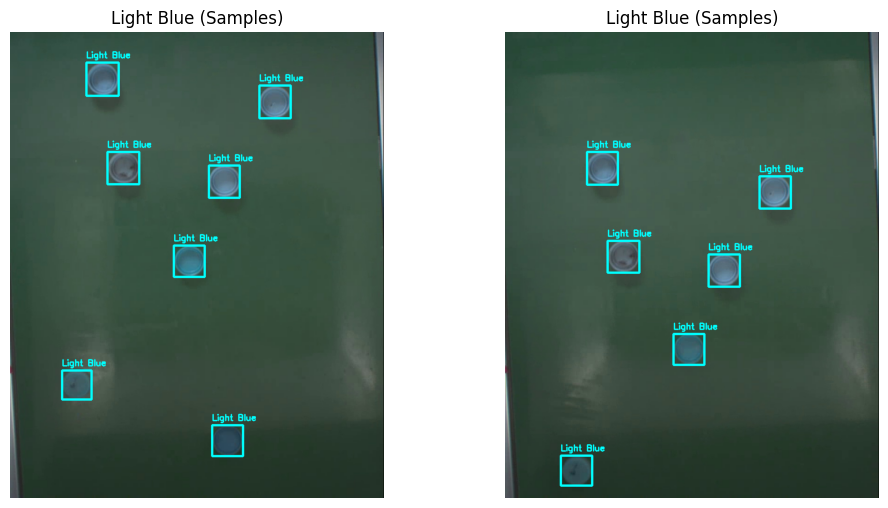

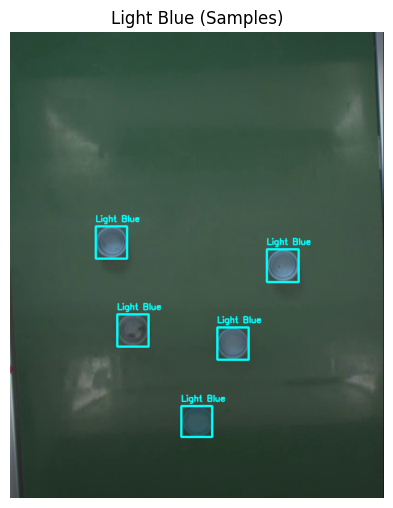

In [3]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import random

# Fungsi Helper untuk menampilkan gambar spesifik per kelas
def show_class_examples(target_class_id, class_name, bbox_color, folder):
    # Cari semua file label di folder train
    if folder == 'train':
        label_files = glob.glob("../datasets/bottle_cap/train/labels/*.txt")
    else:
        label_files = glob.glob("../datasets/bottle_cap/valid/labels/*.txt")

    found_images = []
    
    # Acak biar gak itu-itu aja yang tampil
    random.seed(42)
    random.shuffle(label_files)
    
    for lbl_path in label_files:
        if len(found_images) >= 6: break # Cukup tampilkan 6 gambar
        
        # Cek apakah di file ini ada class yang dicari
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            
        bboxes = []
        has_target = False
        
        for line in lines:
            parts = line.strip().split()
            cls_id = int(parts[0])
            
            # Hanya ambil kotak yang sesuai kategori target
            if cls_id == target_class_id:
                bboxes.append(list(map(float, parts[1:])))
                has_target = True
                
        if has_target:
            # Load gambar
            img_path = lbl_path.replace('labels', 'images').replace('.txt', '.jpg')
            if not os.path.exists(img_path): continue
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape
            
            # Gambar kotak
            for box in bboxes:
                xc, yc, bw, bh = box
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                
                cv2.rectangle(img, (x1, y1), (x2, y2), bbox_color, 3)
                cv2.putText(img, class_name, (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, bbox_color, 2)
            
            found_images.append(img)
    
    # Plotting
    if not found_images:
        print(f"Tidak ditemukan sampel untuk kelas: {class_name}")
        return

    plt.figure(figsize=(15, 10))
    for i, img in enumerate(found_images):
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{class_name} (Samples)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- EKSEKUSI LIGHT BLUE ---
print("Menampilkan sampel LIGHT BLUE (Class 0)...")
# Warna Kotak: Cyan (0, 255, 255)
show_class_examples(0, "Light Blue", (0, 255, 255), 'train')
show_class_examples(0, "Light Blue", (0, 255, 255), 'valid')

Menampilkan sampel DARK BLUE (Class 1)...


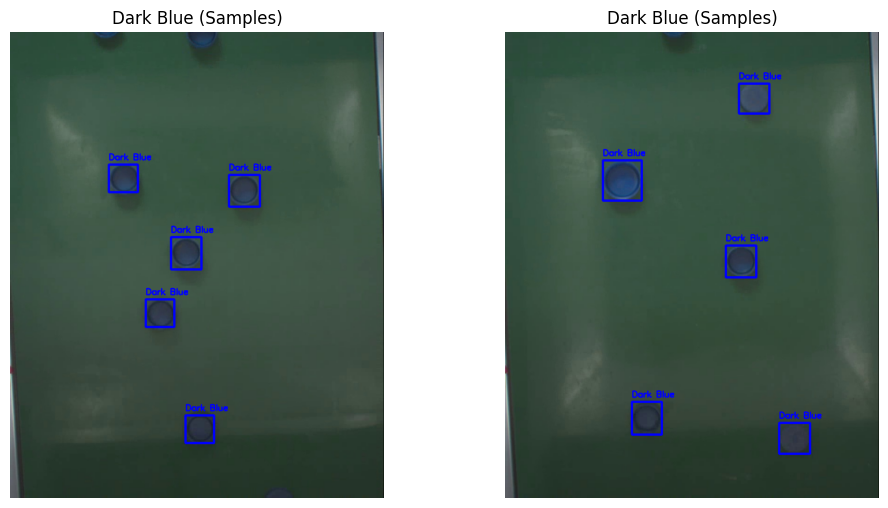

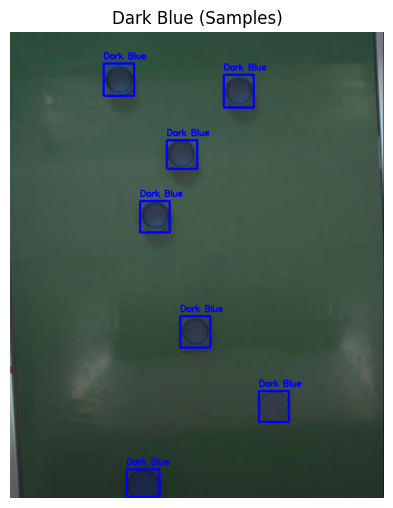

In [4]:
# --- EKSEKUSI DARK BLUE ---
print("Menampilkan sampel DARK BLUE (Class 1)...")
# Warna Kotak: Biru Tua (0, 0, 255) - Di matplotlib jadi Biru
show_class_examples(1, "Dark Blue", (0, 0, 255), 'train')
show_class_examples(1, "Dark Blue", (0, 0, 255), 'valid')

Menampilkan sampel OTHERS (Class 2)...


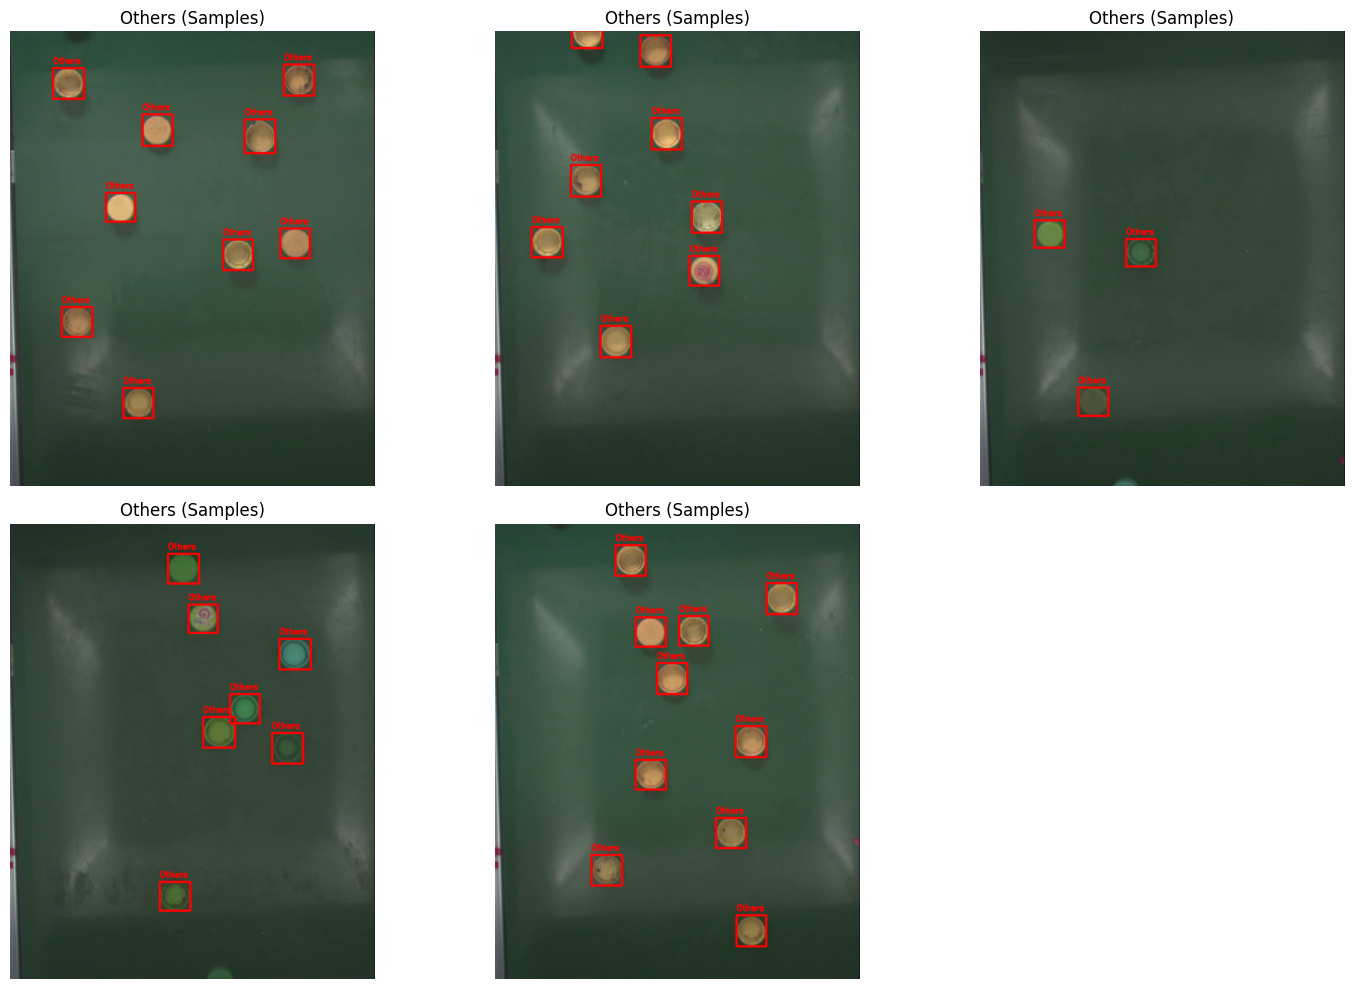

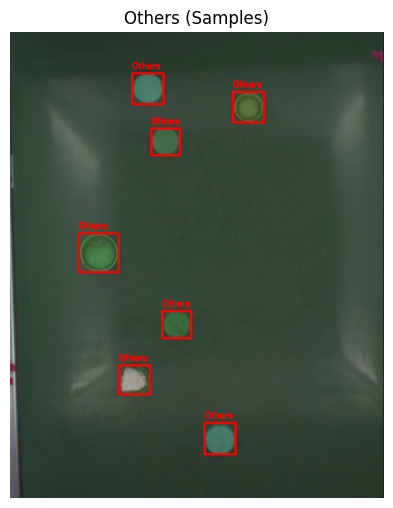

In [5]:
# --- EKSEKUSI OTHERS ---
print("Menampilkan sampel OTHERS (Class 2)...")
# Warna Kotak: Merah (255, 0, 0)
show_class_examples(2, "Others", (255, 0, 0), 'train')
show_class_examples(2, "Others", (255, 0, 0), 'valid')

In [6]:
import yaml
import os

# Path absolut biar aman
dataset_root = os.path.abspath("../datasets/bottle_cap")

data_yaml_content = {
    'path': dataset_root,  # Root folder dataset
    'train': 'train/images', # Lokasi data latih (relatif terhadap 'path')
    'val': 'valid/images',   # Lokasi data validasi
    
    # Definisi Kelas (Harus urut sesuai ID 0, 1, 2)
    'names': {
        0: 'light_blue',
        1: 'dark_blue',
        2: 'others'
    }
}

# Simpan ke file data.yaml di dalam folder dataset
yaml_path = os.path.join(dataset_root, "data.yaml")
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml_content, f, default_flow_style=False)

print(f"File konfigurasi siap di: {yaml_path}")

File konfigurasi siap di: g:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\datasets\bottle_cap\data.yaml


In [7]:
import wandb
from ultralytics import YOLO

# Login ke WandB (Nanti akan muncul input box untuk API Key)
wandb.login()

# # Inisialisasi Project
# wandb.init(project="ada-mata-bottle-cap", name="experiment-1-yolov8n")

wandb: Currently logged in as: wikan (wikan-project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## YOLOv8n

In [8]:
from ultralytics import YOLO
import onnxruntime as ort
import numpy as np
import time

# --- KONFIGURASI BASELINE ---
IMG_SIZE = 640
PROJECT_NAME = "runs/train"
EXP_NAME = "exp_baseline_640"

print(f"🚀 START BASELINE: YOLOv8n @ {IMG_SIZE}px")

# 1. Training Normal
model = YOLO('yolov8n.pt') 
results = model.train(
    data='../datasets/bottle_cap/data.yaml', # Pakai split standar
    epochs=50,
    imgsz=IMG_SIZE,
    batch=8,
    project=PROJECT_NAME, 
    name=EXP_NAME,
    device="cpu",
    plots=True,
    exist_ok=True
)

# 2. Validasi & Benchmark
metrics = model.val()
print(f"--> Akurasi Baseline (mAP@50): {metrics.box.map50:.2%}")

print("📦 Exporting Baseline to ONNX...")
onnx_path = model.export(format='onnx', dynamic=False, opset=12, imgsz=IMG_SIZE)

# Benchmark Singkat
session = ort.InferenceSession(onnx_path)
dummy_input = np.random.randn(1, 3, IMG_SIZE, IMG_SIZE).astype(np.float32)
start = time.time()
for _ in range(50): session.run(None, {session.get_inputs()[0].name: dummy_input})
avg_ms = (time.time() - start) / 50 * 1000
print(f"⏱️ Speed Baseline: {avg_ms:.2f} ms")

🚀 START BASELINE: YOLOv8n @ 640px
New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/bottle_cap/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name

### Change size into 320

In [9]:
# 1. Load Model Baseline tadi
model = YOLO(f'{PROJECT_NAME}/{EXP_NAME}/weights/best.pt') 

# 2. Export Paksa ke 320px
print("\n📉 Eksperimen Resize: Export Model 640px ke ONNX 320px...")
onnx_path_320 = model.export(format='onnx', dynamic=False, imgsz=320, opset=12)

# 3. Validasi & Benchmark
# Kita validasi pakai imgsz=320 untuk lihat penurunan akurasinya
metrics_resize = model.val(data='../datasets/bottle_cap/data.yaml', imgsz=320, split='val')
print(f"--> Akurasi Resize (mAP@50): {metrics_resize.box.map50:.2%}")

# Benchmark Speed
session = ort.InferenceSession(onnx_path_320)
dummy_input = np.random.randn(1, 3, 320, 320).astype(np.float32)
start = time.time()
for _ in range(100): session.run(None, {session.get_inputs()[0].name: dummy_input})
avg_ms = (time.time() - start) / 100 * 1000
print(f"⏱️ Speed Resize 320px: {avg_ms:.2f} ms")


📉 Eksperimen Resize: Export Model 640px ke ONNX 320px...
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\train\exp_baseline_640\weights\best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 7, 2100) (6.0 MB)

ONNX: starting export with onnx 1.19.1 opset 12...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success  2.1s, saved as 'runs\train\exp_baseline_640\weights\best.onnx' (11.6 MB)

Export complete (2.7s)
Results saved to G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_baseline_640\weights
Predict:         yolo predict task=detect model=runs\train\exp_baseline_640\weights\best.onnx imgsz=320  
Validate:        yolo val task=detect model=runs\train\exp_baseline_640\weights\best.onnx imgsz=320 data=../datasets/bottle_cap/data.yaml  
Visualize:       https://ne

### Augmentation

In [10]:
# Reset Model
model = YOLO('yolov8n.pt') 

print("\n🚀 TRAINING FINAL: 320px Optimized + Safe Augmentation")

results = model.train(
    data='../datasets/bottle_cap/data.yaml',
    imgsz=320,      # Wajib 320 biar ngebut
    epochs=50,
    batch=16,
    patience=15,
    project='runs/train',
    name='final_optimized_320',
    device='cpu',
    
    # === SETTINGAN PENYELAMAT (SAFE) ===
    # Matikan Augmentasi Berat yang bikin akurasi 50%
    mosaic=0.0,     
    scale=0.1,      # Zoom dikit aja
    degrees=0.0,    # Jangan putar dulu biar stabil
    
    # Matikan Warna (Wajib)
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0
)

# Validasi Final
metrics_final = model.val()
print(f"🏆 Akurasi Final (mAP@50): {metrics_final.box.map50:.2%}")


🚀 TRAINING FINAL: 320px Optimized + Safe Augmentation
New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/bottle_cap/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, mu

### FP16

In [11]:
# Pastikan install openvino 2024 dulu kalau belum (lewat terminal)
from ultralytics import YOLO
import time
import os

# 1. Load Model Final tadi
model = YOLO('runs/train/final_optimized_320/weights/best.pt')
import shutil
from pathlib import Path

# Hapus folder export lama jika ada (Biar gak error file locked)
ov_path = Path('runs/train/final_optimized_320/weights/best_openvino_model')
if ov_path.exists():
    try:
        shutil.rmtree(ov_path)
        print(f"🗑️ Folder lama dihapus: {ov_path}")
    except OSError as e:
        print("⚠️ Gagal hapus folder (masih terkunci). Restart Kernel dulu!")
print("\n🚀 ELASTIC MOVE: Exporting to INT8 Quantization...")
model.export(
    format='openvino', 
    imgsz=320, 
    half=True, # Kuncinya di sini
    data='../datasets/bottle_cap/data.yaml' # Data untuk kalibrasi
)

# 2. Cari Path Model OpenVINO
# Biasanya ada di folder: runs/train/final_optimized_320/weights/best_openvino_model/
ov_model_path = 'runs/train/final_optimized_320/weights/best_openvino_model/'

if os.path.exists(ov_model_path):
    print(f"✅ Model FP16 Siap di: {ov_model_path}")
    
    # Benchmark INT8
    ov_model = YOLO(ov_model_path)
    
    # Warmup
    ov_model.predict(source='../datasets/bottle_cap/train/images/raw-250110_dc_s001_b2_1.jpg', imgsz=320, verbose=False)
    
    start = time.time()
    for _ in range(100):
        ov_model.predict(source='../datasets/bottle_cap/train/images/raw-250110_dc_s001_b2_1.jpg', imgsz=320, verbose=False)
    avg_ms = (time.time() - start) / 100 * 1000
    
    print(f"⚡ SPEED INT8: {avg_ms:.2f} ms")
else:
    print("⚠️ Folder OpenVINO tidak ditemukan otomatis. Cek folder runs/train.")

🗑️ Folder lama dihapus: runs\train\final_optimized_320\weights\best_openvino_model

🚀 ELASTIC MOVE: Exporting to INT8 Quantization...
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\train\final_optimized_320\weights\best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 7, 2100) (5.9 MB)

OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...
OpenVINO: export success  10.3s, saved as 'runs\train\final_optimized_320\weights\best_openvino_model\' (6.0 MB)

Export complete (10.9s)
Results saved to G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\final_optimized_320\weights
Predict:         yolo predict task=detect model=runs\train\final_optimized_320\weights\best_openvino_model imgsz=320 half 
Validate:        yolo val task=detect model=runs\trai

## 4-Folds

In [12]:
import os
import random
from pathlib import Path
import yaml
import numpy as np
from ultralytics import YOLO

# =======================
# 1. KONFIGURASI DASAR
# =======================
# Pastikan path absolut agar YOLO tidak bingung
DATASET_ROOT = Path("../datasets/bottle_cap").resolve()

TRAIN_IMAGES = DATASET_ROOT / "train" / "images"
VALID_IMAGES = DATASET_ROOT / "valid" / "images"

# Settings Model
IMG_SIZE = 320         # Optimized for speed
MODEL_WEIGHTS = "yolov8n.pt"
K_FOLDS = 4
EPOCHS = 50            # Naikkan ke 50
PATIENCE = 10          # Early Stopping

CLASS_NAMES = ["light_blue", "dark_blue", "others"]
NC = len(CLASS_NAMES)

# Folder config disimpan DI DALAM dataset root
CFG_DIR = DATASET_ROOT / "kfold_configs"
CFG_DIR.mkdir(exist_ok=True)

PROJECT_NAME = "runs/kfold"
random.seed(42)

# =======================
# 2. FUNGSI HELPER
# =======================
def get_label(img_path: Path) -> Path:
    img_parts = list(img_path.parts)
    try:
        idx = img_parts.index("images")
    except ValueError:
        return Path("invalid")
    img_parts[idx] = "labels"
    return Path(*img_parts).with_suffix(".txt")

# =======================
# 3. SIAPKAN DATA
# =======================
all_images = list(TRAIN_IMAGES.glob("*.jpg")) + list(VALID_IMAGES.glob("*.jpg"))
all_images = sorted([p.resolve() for p in all_images])

pairs = []
for img in all_images:
    label = get_label(img)
    if label.exists():
        pairs.append((img, label))
    else:
        print(f"⚠️ Label missing for: {img.name}")

num_samples = len(pairs)
print(f"Total Data Valid: {num_samples} gambar")

if num_samples < K_FOLDS:
    K_FOLDS = num_samples

random.shuffle(pairs)

# =======================
# 4. BAGI DATA JADI FOLDS
# =======================
fold_sizes = [num_samples // K_FOLDS] * K_FOLDS
for i in range(num_samples % K_FOLDS):
    fold_sizes[i] += 1

folds = []
idx = 0
for fs in fold_sizes:
    folds.append(pairs[idx:idx+fs])
    idx += fs

# =======================
# 5. LOOP TRAINING (K-FOLD)
# =======================
scores = []
best_onnx_path = ""
best_map = 0.0

print(f"\n🚀 MEMULAI {K_FOLDS}-FOLD CROSS VALIDATION")
print(f"   Target: {EPOCHS} Epochs | Patience: {PATIENCE} | Input: {IMG_SIZE}px")

for k in range(K_FOLDS):
    print(f"\n---------------------------------------")
    print(f"🔄 TRAINING FOLD {k+1}/{K_FOLDS}")
    print(f"---------------------------------------")

    val_pairs = folds[k]
    train_pairs = [p for i, f in enumerate(folds) if i != k for p in f]

    # Setup Config Files
    train_txt = CFG_DIR / f"train_fold_{k}.txt"
    val_txt = CFG_DIR / f"val_fold_{k}.txt"

    with open(train_txt, "w") as f:
        for img, _ in train_pairs:
            f.write(str(img) + "\n")

    with open(val_txt, "w") as f:
        for img, _ in val_pairs:
            f.write(str(img) + "\n")

    yaml_content = {
        'path': str(DATASET_ROOT), 
        'train': str(train_txt),   
        'val': str(val_txt),       
        'nc': NC,
        'names': CLASS_NAMES,
    }

    yaml_path = CFG_DIR / f"data_fold_{k}.yaml"
    with open(yaml_path, "w") as f:
        yaml.dump(yaml_content, f)

    # Train
    model = YOLO(MODEL_WEIGHTS)
    results = model.train(
        data=str(yaml_path),
        epochs=EPOCHS,
        patience=PATIENCE,
        imgsz=IMG_SIZE,
        batch=8,
        device="cpu",
        project=PROJECT_NAME,
        name=f"fold_{k}",
        verbose=False,
        plots=False
    )

    # Record Score
    map50 = results.box.map50
    scores.append(map50)
    print(f"✅ Fold {k+1} Result: mAP@50 = {map50:.2%}")

    # --- BAGIAN BARU: EXPORT ONNX ---
    print(f"📦 Exporting Fold {k+1} to ONNX...")
    # Export model ini ke ONNX
    onnx_path = model.export(
        format='onnx',
        imgsz=IMG_SIZE,
        dynamic=False,
        opset=12
    )
    
    # Simpan path model terbaik untuk referensi user
    if map50 > best_map:
        best_map = map50
        best_onnx_path = onnx_path
        print(f"⭐ New Best Model Found! ({map50:.2%})")

# =======================
# 6. HASIL AKHIR
# =======================
scores = np.array(scores)
print("\n\n🏆 === LAPORAN AKHIR K-FOLD CV ===")
print(f"Skor per Fold : {[f'{s:.2%}' for s in scores]}")
print(f"Rata-rata     : {scores.mean():.2%}")
print(f"Lokasi ONNX Terbaik: {best_onnx_path}")

Total Data Valid: 12 gambar

🚀 MEMULAI 4-FOLD CROSS VALIDATION
   Target: 50 Epochs | Patience: 10 | Input: 320px

---------------------------------------
🔄 TRAINING FOLD 1/4
---------------------------------------
New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\datasets\bottle_cap\kfold_configs\data_fold_0.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fracti

## YOLOv10n

In [13]:
from ultralytics import YOLO
import onnxruntime as ort
import numpy as np
import time

# --- KONFIGURASI ---
IMG_SIZE = 320
PROJECT_NAME = "runs/train"
EXP_NAME = "exp_baseline_yolov10n"

print(f"MEMULAI EKSPERIMEN BASELINE (Input: {IMG_SIZE}x{IMG_SIZE})...")

# 1. Load Model & Training
model = YOLO('yolov10n.pt') 

results = model.train(
    data='../datasets/bottle_cap/data.yaml',
    epochs=50,
    imgsz=IMG_SIZE,
    batch=8,
    project=PROJECT_NAME, 
    name=EXP_NAME,
    device="cpu",
    plots=True,
    exist_ok=True # Timpa folder jika sudah ada (biar gak error exp2, exp3, dst)
)

# 2. Validasi (Cek Akurasi)
print("\nMelakukan Validasi Model...")
metrics = model.val()
print(f"--> mAP@50: {metrics.box.map50:.2%}")
print(f"--> mAP@50-95: {metrics.box.map:.2%}")

# 3. Export ke ONNX (Satu kali saja!)
print("\nMeng-export model ke ONNX...")
# Fungsi export mengembalikan path file outputnya, kita tangkap di variabel
onnx_path = model.export(format='onnx', dynamic=False, opset=12, imgsz=IMG_SIZE)
print(f"--> Model ONNX tersimpan di: {onnx_path}")

# 4. Benchmark Kecepatan (Inferensi)
print(f"\nMemulai Benchmark Kecepatan ({IMG_SIZE}px)...")

# Load ONNX Session
session = ort.InferenceSession(onnx_path)
input_name = session.get_inputs()[0].name

# Buat data dummy sesuai ukuran gambar (Batch 1, 3 Channel, H, W)
dummy_input = np.random.randn(1, 3, IMG_SIZE, IMG_SIZE).astype(np.float32)

# Pemanasan (Warmup) - Biar CPU 'panas' dulu
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# Tes Loop 100 kali
start_time = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end_time = time.time()

# Hitung Rata-rata
avg_time = (end_time - start_time) / 100 * 1000 # ms
fps = 1000 / avg_time

print("\n=== HASIL AKHIR BASELINE (640px) ===")
print(f"Rata-rata Waktu: {avg_time:.2f} ms")
print(f"Estimasi FPS:    {fps:.1f} FPS")

if avg_time <= 10:
    print("✅ TARGET TERCAPAI!")
else:
    print(f"BELUM TERCAPAI. Masih {avg_time:.2f}ms (Target: 5-10ms).")
    print("   -> Lanjut ke strategi optimasi berikutnya (Resize 320px).")

MEMULAI EKSPERIMEN BASELINE (Input: 320x320)...
New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/bottle_cap/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_sc

## YOLO9t

In [14]:
from ultralytics import YOLO
import onnxruntime as ort
import numpy as np
import time

# --- KONFIGURASI ---
IMG_SIZE = 320
PROJECT_NAME = "runs/train"
EXP_NAME = "exp_baseline_yolov9t"

print(f"MEMULAI EKSPERIMEN BASELINE (Input: {IMG_SIZE}x{IMG_SIZE})...")

# 1. Load Model & Training
model = YOLO('yolov9t.pt') 

results = model.train(
    data='../datasets/bottle_cap/data.yaml',
    epochs=50,
    imgsz=IMG_SIZE,
    batch=8,
    project=PROJECT_NAME, 
    name=EXP_NAME,
    device="cpu",
    plots=True,
    exist_ok=True # Timpa folder jika sudah ada (biar gak error exp2, exp3, dst)
)

# 2. Validasi (Cek Akurasi)
print("\nMelakukan Validasi Model...")
metrics = model.val()
print(f"--> mAP@50: {metrics.box.map50:.2%}")
print(f"--> mAP@50-95: {metrics.box.map:.2%}")

# 3. Export ke ONNX (Satu kali saja!)
print("\nMeng-export model ke ONNX...")
# Fungsi export mengembalikan path file outputnya, kita tangkap di variabel
onnx_path = model.export(format='onnx', dynamic=False, opset=12, imgsz=IMG_SIZE)
print(f"--> Model ONNX tersimpan di: {onnx_path}")

# 4. Benchmark Kecepatan (Inferensi)
print(f"\nMemulai Benchmark Kecepatan ({IMG_SIZE}px)...")

# Load ONNX Session
session = ort.InferenceSession(onnx_path)
input_name = session.get_inputs()[0].name

# Buat data dummy sesuai ukuran gambar (Batch 1, 3 Channel, H, W)
dummy_input = np.random.randn(1, 3, IMG_SIZE, IMG_SIZE).astype(np.float32)

# Pemanasan (Warmup) - Biar CPU 'panas' dulu
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# Tes Loop 100 kali
start_time = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end_time = time.time()

# Hitung Rata-rata
avg_time = (end_time - start_time) / 100 * 1000 # ms
fps = 1000 / avg_time

print("\n=== HASIL AKHIR BASELINE (320px) ===")
print(f"Rata-rata Waktu: {avg_time:.2f} ms")
print(f"Estimasi FPS:    {fps:.1f} FPS")

if avg_time <= 10:
    print("✅ TARGET TERCAPAI!")
else:
    print(f"BELUM TERCAPAI. Masih {avg_time:.2f}ms (Target: 5-10ms).")
    print("   -> Lanjut ke strategi optimasi berikutnya (Resize 320px).")

MEMULAI EKSPERIMEN BASELINE (Input: 320x320)...
New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/bottle_cap/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9t.pt, momentum=0.937, mosaic=1.0, multi_sca

## YOLOv5nu

In [15]:
from ultralytics import YOLO
import onnxruntime as ort
import numpy as np
import time

# --- KONFIGURASI ---
IMG_SIZE = 320
PROJECT_NAME = "runs/train"
EXP_NAME = "exp_baseline_yolo5nu"

print(f"MEMULAI EKSPERIMEN BASELINE (Input: {IMG_SIZE}x{IMG_SIZE})...")

# 1. Load Model & Training
model = YOLO('yolov5nu.pt') 

results = model.train(
    data='../datasets/bottle_cap/data.yaml',
    epochs=50,
    imgsz=IMG_SIZE,
    batch=8,
    project=PROJECT_NAME, 
    name=EXP_NAME,
    device="cpu",
    plots=True,
    exist_ok=True # Timpa folder jika sudah ada (biar gak error exp2, exp3, dst)
)

# 2. Validasi (Cek Akurasi)
print("\nMelakukan Validasi Model...")
metrics = model.val()
print(f"--> mAP@50: {metrics.box.map50:.2%}")
print(f"--> mAP@50-95: {metrics.box.map:.2%}")

# 3. Export ke ONNX (Satu kali saja!)
print("\nMeng-export model ke ONNX...")
# Fungsi export mengembalikan path file outputnya, kita tangkap di variabel
onnx_path = model.export(format='onnx', dynamic=False, opset=12, imgsz=IMG_SIZE)
print(f"--> Model ONNX tersimpan di: {onnx_path}")

# 4. Benchmark Kecepatan (Inferensi)
print(f"\nMemulai Benchmark Kecepatan ({IMG_SIZE}px)...")

# Load ONNX Session
session = ort.InferenceSession(onnx_path)
input_name = session.get_inputs()[0].name

# Buat data dummy sesuai ukuran gambar (Batch 1, 3 Channel, H, W)
dummy_input = np.random.randn(1, 3, IMG_SIZE, IMG_SIZE).astype(np.float32)

# Pemanasan (Warmup) - Biar CPU 'panas' dulu
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# Tes Loop 100 kali
start_time = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end_time = time.time()

# Hitung Rata-rata
avg_time = (end_time - start_time) / 100 * 1000 # ms
fps = 1000 / avg_time

print("\n=== HASIL AKHIR BASELINE (320px) ===")
print(f"Rata-rata Waktu: {avg_time:.2f} ms")
print(f"Estimasi FPS:    {fps:.1f} FPS")

if avg_time <= 10:
    print("✅ TARGET TERCAPAI!")
else:
    print(f"BELUM TERCAPAI. Masih {avg_time:.2f}ms (Target: 5-10ms).")
    print("   -> Lanjut ke strategi optimasi berikutnya (Resize 320px).")

MEMULAI EKSPERIMEN BASELINE (Input: 320x320)...
New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/bottle_cap/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5nu.pt, momentum=0.937, mosaic=1.0, multi_sc

## YOLO11n

In [16]:
from ultralytics import YOLO
import onnxruntime as ort
import numpy as np
import time

# --- KONFIGURASI ---
IMG_SIZE = 320
PROJECT_NAME = "runs/train"
EXP_NAME = "exp_baseline_yolo11n"

print(f"MEMULAI EKSPERIMEN BASELINE (Input: {IMG_SIZE}x{IMG_SIZE})...")

# 1. Load Model & Training
model = YOLO('yolo11n.pt') 

results = model.train(
    data='../datasets/bottle_cap/data.yaml',
    epochs=50,
    imgsz=IMG_SIZE,
    batch=8,
    project=PROJECT_NAME, 
    name=EXP_NAME,
    device="cpu",
    plots=True,
    exist_ok=True # Timpa folder jika sudah ada (biar gak error exp2, exp3, dst)
)

# 2. Validasi (Cek Akurasi)
print("\nMelakukan Validasi Model...")
metrics = model.val()
print(f"--> mAP@50: {metrics.box.map50:.2%}")
print(f"--> mAP@50-95: {metrics.box.map:.2%}")

# 3. Export ke ONNX (Satu kali saja!)
print("\nMeng-export model ke ONNX...")
# Fungsi export mengembalikan path file outputnya, kita tangkap di variabel
onnx_path = model.export(format='onnx', dynamic=False, opset=12, imgsz=IMG_SIZE)
print(f"--> Model ONNX tersimpan di: {onnx_path}")

# 4. Benchmark Kecepatan (Inferensi)
print(f"\nMemulai Benchmark Kecepatan ({IMG_SIZE}px)...")

# Load ONNX Session
session = ort.InferenceSession(onnx_path)
input_name = session.get_inputs()[0].name

# Buat data dummy sesuai ukuran gambar (Batch 1, 3 Channel, H, W)
dummy_input = np.random.randn(1, 3, IMG_SIZE, IMG_SIZE).astype(np.float32)

# Pemanasan (Warmup) - Biar CPU 'panas' dulu
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# Tes Loop 100 kali
start_time = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end_time = time.time()

# Hitung Rata-rata
avg_time = (end_time - start_time) / 100 * 1000 # ms
fps = 1000 / avg_time

print("\n=== HASIL AKHIR BASELINE (320px) ===")
print(f"Rata-rata Waktu: {avg_time:.2f} ms")
print(f"Estimasi FPS:    {fps:.1f} FPS")

if avg_time <= 10:
    print("✅ TARGET TERCAPAI!")
else:
    print(f"BELUM TERCAPAI. Masih {avg_time:.2f}ms (Target: 5-10ms).")
    print("   -> Lanjut ke strategi optimasi berikutnya (Resize 320px).")

MEMULAI EKSPERIMEN BASELINE (Input: 320x320)...
New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/bottle_cap/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_sca

### Augmentation

In [ ]:
from ultralytics import YOLO

# 1. Load Model Terbaru (YOLO11 Nano)
# Pastikan library ultralytics sudah paling update (poetry update ultralytics)
model = YOLO('yolo11n.pt') 

print("🚀 Mulai Training YOLO11n dengan 'Safe Augmentation'...")

results = model.train(
    data='../datasets/bottle_cap/kfold_configs/data_fold_0.yaml', # Pakai Fold 0 aja buat demo
    epochs=50,
    imgsz=320,      # Kunci kecepatan! (Jangan 640)
    batch=8,
    patience=15,    # Kasih sabar dikit karena augmentation bikin belajar lebih susah di awal
    device='cpu',
    project='runs/train',
    name='exp_yolo11_aug',
    
    # === KONFIGURASI AUGMENTASI (Safety First) ===
    # Matikan perubahan warna agar Light/Dark Blue tidak tertukar
    hsv_h=0.0,      # Hue (Warna) -> JANGAN UBAH
    hsv_s=0.0,      # Saturation -> JANGAN UBAH
    hsv_v=0.0,      # Value (Terang/Gelap) -> JANGAN UBAH (Krusial buat Light vs Dark)
    
    # Genjot di perubahan bentuk/posisi (Biar pinter)
    degrees=15.0,   # Putar-putar dikit +/- 15 derajat
    translate=0.1,  # Geser-geser 10%
    scale=0.5,      # Zoom in/out 50% (Biar kenal botol jauh/dekat)
    fliplr=0.5,     # Cermin kiri-kanan (50% peluang)
    mosaic=1.0,     # Gabung 4 gambar jadi 1 (Wajib buat dataset kecil)
    mixup=0.1,      # Tumpuk gambar transparan (Dikit aja)
)

# Validasi
print("\n📊 Validasi Awal...")
metrics = model.val()
print(f"mAP@50: {metrics.box.map50:.2%}")

# EXPORT KE ONNX (Supaya 28ms turun jadi <15ms)
print("\n📦 Export ke ONNX (Speed Optimization)...")
onnx_path = model.export(format='onnx', imgsz=320, dynamic=False, opset=12)

🚀 Mulai Training YOLO11n dengan 'Safe Augmentation'...
New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.11.9 torch-2.4.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/bottle_cap/kfold_configs/data_fold_0.yaml, degrees=15.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11n.pt, momentum=

In [ ]:
import time
import onnxruntime as ort
import numpy as np

# Path ke model ONNX hasil training YOLO11 tadi
onnx_path = "runs/train/exp_yolo11_aug/weights/best.onnx"

print(f"\n⏱️ Benchmark ONNX ({onnx_path})...")

# Load ONNX Session
session = ort.InferenceSession(str(onnx_path))
input_name = session.get_inputs()[0].name

# Dummy Input 320px
dummy_input = np.random.randn(1, 3, 320, 320).astype(np.float32)

# Warmup (Biar CPU panas)
print("   Warming up...")
for _ in range(10): 
    session.run(None, {input_name: dummy_input})

# Test Loop (Beneran)
print("   Running 100 inferences...")
start = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end = time.time()

avg_ms = (end - start) / 100 * 1000
fps = 1000 / avg_ms

print(f"\n=== HASIL AKHIR (YOLO11n @ 320px) ===")
print(f"Speed: {avg_ms:.2f} ms")
print(f"FPS:   {fps:.1f}")

if avg_ms < 15:
    print("✅ TARGET TERCAPAI (<15ms)!")
else:
    print("⚠️ Masih agak lambat.")


⏱️ Benchmark ONNX (runs/train/exp_yolo11_aug/weights/best.onnx)...
   Warming up...
   Running 100 inferences...

=== HASIL AKHIR (YOLO11n @ 320px) ===
Speed: 33.87 ms
FPS:   29.5
⚠️ Masih agak lambat.


### FP16